# Select GTEx-1000 Set

In [35]:
import pandas as pd
import os
from gene_outlier_detection.lib import anova_distances
from collections import defaultdict
import shutil

In [2]:
tumor = pd.read_hdf('/mnt/data/outlier/tumor.hd5')
gtex = pd.read_hdf('/mnt/data/outlier/gtex.hd5')
genes = tumor.columns[5:]

In [169]:
counts = tumor.groupby('tissue')['subtype'].value_counts().reset_index(name='Counts')
counts.index = counts.subtype
counts.head(2)

,tissue,subtype,Counts
subtype,,,
Pheochromocytoma_and_Paraganglioma,Adrenal,Pheochromocytoma_and_Paraganglioma,177
Adrenocortical_Carcinoma,Adrenal,Adrenocortical_Carcinoma,77


In [170]:
out_dir = '/mnt/normsd-outlier-runs/gtex-1000/'
old_samples = os.listdir(out_dir)
len(old_samples)

976

For each tissue select one subtype and remove samples that didn't match to the correct weight

In [173]:
run_dir = '/mnt/normsd-outlier-runs/gtex-1000/'
new_samples = []
tissues = tumor['tissue']
subtypes = tumor['subtype']
subtypes_to_remove =[
    'Pheochromocytoma_and_Paraganglioma',
    'Glioblastoma_Multiforme',
    'Lung_Squamous_Cell_Carcinoma',
    'Kidney_Renal_Papillary_Cell_Carcinoma',
    'Kidney_Chromophobe',
]

for sample in old_samples:
    tissue = tissues.loc[sample]
    subtype = subtypes.loc[sample]
    if subtype in subtypes_to_remove:
        continue
    #weight_path = os.path.join(out_dir, sample, 'weights.tsv')
    #w = pd.read_csv(weight_path, sep='\t', index_col=0)
    #if tissue not in w.index:
    #    continue
    new_samples.append([sample, tissue, subtype])
new_samples = pd.DataFrame(new_samples, columns=['sample', 'tissue', 'subtype'])

Fill out gaps

In [174]:
new_samples['tissue'].value_counts()

Breast      100
Liver       100
Prostate    100
Stomach     100
Bladder     100
Lung        100
Brain       100
Thyroid     100
Kidney       99
Adrenal      77
Name: tissue, dtype: int64

In [175]:
reqs = [
    ('Stomach', 'Stomach_Adenocarcinoma', 2),
    ('Breast', 'Breast_Invasive_Carcinoma', 7),
    ('Brain', 'Brain_Lower_Grade_Glioma', 11),
    ('Bladder', 'Bladder_Urothelial_Carcinoma', 21),
    ('Lung', 'Lung_Adenocarcinoma', 26),
    ('Kidney','Kidney_Renal_Clear_Cell_Carcinoma', 51),
]

reqs = [('Kidney', 'Kidney_Renal_Clear_Cell_Carcinoma', 1)]

In [177]:
added_samples = defaultdict(list)
for tissue, subtype, n in reqs:
    print(f'== {tissue} ==')
    samples = tumor[tumor.subtype == subtype]['id']
    samples = [x for x in samples if x not in old_samples]
    for i, sample_id in enumerate(samples):
        sample = tumor.loc[sample_id]
        dist = anova_distances(sample, gtex, genes)
        if tissue in list(dist.head(3).Group):
            added_samples[tissue].append(sample_id)
            print(f'Added {sample_id} - {len(added_samples[tissue])}')
            if len(added_samples[tissue]) == n or counts.loc[subtype].Counts == i:
                break

== Kidney ==
Ranking background datasets by tissue via ANOVA
Ranking background datasets by tissue via ANOVA
Ranking background datasets by tissue via ANOVA
Added TCGA-B8-5159-01 - 1


Add all Adrenal since there are fewer than 100 Adrenocortical carcinomas

In [21]:
new_adrenal = list(tumor[tumor.subtype == 'Adrenocortical_Carcinoma']['id'])
new_adrenal = [x for x in new_adrenal if x not in old_samples]

In [22]:
added_samples['Adrenal'] = new_adrenal

## Make manifest for GTEx-1000

In [24]:
manifest_samples = []
for k, v in added_samples.items():
    for sample in v:
        manifest_samples.append(sample)
len(manifest_samples)

In [26]:
out_dir = '/mnt/data/outlier/gtex-1000'
with open(os.path.join(out_dir, 'added_samples_manifest.txt'), 'w') as f:
    for sample in manifest_samples:
        f.write(f'{sample}\n')

Complete manifest for reference

In [ ]:
len(total)

In [33]:
total = list(new_samples['sample']) + manifest_samples
with open(os.path.join(out_dir, 'manifest.txt'), 'w') as f:
    for sample in total:
        f.write(f'{sample}\n')

## Manifest for GTEx-1000-Match-Remove

In [34]:
with open(os.path.join(out_dir, 'added-mr-manifest.tsv'), 'w') as f:
    f.write('sample\tbackground\n')
    for sample in manifest_samples:
        tissue = tissues.loc[sample]
        f.write(f'{sample}\t/mnt/inputs/gtex-{tissue}-removed.hd5\n')

## Move old samples

### GTEx-1000

In [36]:
samples_to_move = []
for sample in os.listdir('/mnt/normsd-outlier-runs/gtex-1000/'):
    if sample not in total:
        samples_to_move.append(sample)

In [59]:
for sample in samples_to_move:
    shutil.move(
        os.path.join('/mnt/normsd-outlier-runs/gtex-1000/', sample),
        os.path.join('/mnt/normsd-outlier-runs/OLD-GTEX-1000')
    )

### GTEx-1000-Match-Remove

In [77]:
for sample in samples_to_move:
    shutil.move(
        os.path.join('/mnt/normsd-outlier-runs/gtex-1000-match-removed/', sample),
        os.path.join('/mnt/normsd-outlier-runs/OLD-GTEX-1000-MATCH-REMOVED/')
    )

## Count samples with matches to Minor Salivary Gland
Minor salivary gland clusters near a bunch of phenotypically different tissues and is probably best removed from the background dataset

In [163]:
out_dir = '/mnt/normsd-outlier-runs/gtex-1000/'
minor_samples = []
samples = os.listdir(out_dir)
for sample in samples:
    tissue = tissues.loc[sample]
    w_path = os.path.join(out_dir, sample, 'weights.tsv')
    w = pd.read_csv(w_path, sep='\t', index_col=0)
    if 'Minor' in w.index:
        minor_samples.append([sample, w.loc['Minor'].Median, tissue])

columns = ['Sample', 'Minor_median', 'tissue']
minor_samples = pd.DataFrame(minor_samples, columns=columns)

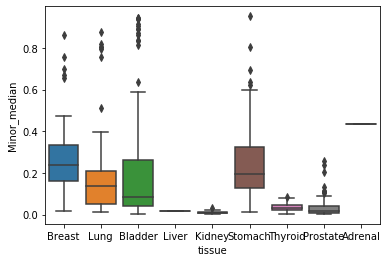

In [164]:
sns.boxplot(data=minor_samples, x='tissue', y='Minor_median')

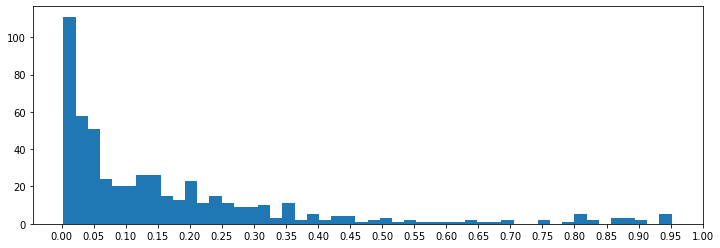

In [165]:
plt.figure(figsize=(12, 4))
plt.hist(minor_samples.Minor_median, bins=50);
plt.xticks(np.arange(0, 1.05, 0.05));

In [178]:
cutoff = 0.0
cut = minor_samples[minor_samples.Minor_median > cutoff]

In [179]:
cut['tissue'].value_counts()

Bladder     96
Lung        94
Prostate    92
Stomach     88
Breast      86
Thyroid     38
Kidney      29
Adrenal      1
Liver        1
Name: tissue, dtype: int64

In [180]:
cut['tissue'].value_counts().sum()

525

In [162]:
manifest_out = '/mnt/data/outlier/gtex-1000/minor-remove-manifest.txt'
with open(manifest_out, 'w') as f:
    f.write('\n'.join(cut.Sample))

## Move minor-matched samples

In [ ]:
samples_to_move = list(cut.Sample)
for sample in samples_to_move:
    shutil.move(
        f'/mnt/normsd-outlier-runs/gtex-1000/{sample}',
        '/mnt/normsd-outlier-runs/OLD-MINOR-REMOVED'
    )

# Compare PCA dist vs just dist

In [49]:
from sklearn.metrics import pairwise_distances
from gene_outlier_detection.lib import select_k_best_genes
import numpy as np

In [182]:
sample_id = 'TCGA-5N-A9KI-01'
sample = tumor.loc[sample_id]

In [183]:
dist = pairwise_distances(np.array(sample[genes]).reshape(1, -1), gtex[genes])
dist = pd.DataFrame([dist.ravel(), gtex['tissue']]).T
dist.columns = ["Distance", "Group"]

# Median by group and sort
med_dist = (dist.groupby("Group").apply(lambda x: x["Distance"].median()).reset_index())
med_dist.columns = ["Group", "MedianDistance"]
med_dist.sort_values("MedianDistance").reset_index(drop=True).head(5)

,Group,MedianDistance
0,Minor,202.559630
1,Bladder,208.801398
2,Stomach,215.904772
3,Vagina,217.465664
4,Small_intestine,219.003506


In [184]:
anova_distances(sample, gtex, genes, n_genes=2654).head(5)

Ranking background datasets by tissue via ANOVA


,Group,MedianDistance
0,Minor,59.243243
1,Stomach,60.114767
2,Bladder,61.815285
3,Small_intestine,65.479787
4,Vagina,66.430839


In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

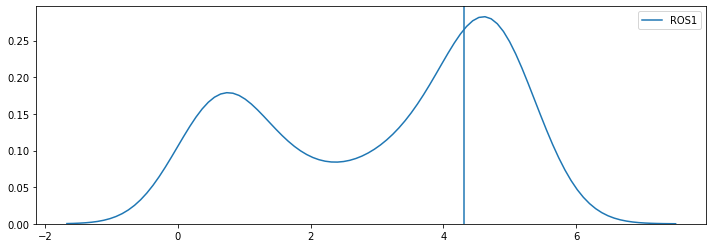

In [154]:
plt.figure(figsize=(12, 4))
plt.axvline(sample['ROS1'])
sns.kdeplot(gtex[gtex.tissue == 'Lung']['ROS1'])